In [12]:
import SymbolList as sl
import Analyze as an
import numpy as np
import pandas as pd
import datetime as dt 
from statsmodels.formula.api import ols 
import seaborn as sns;  sns.set()
import matplotlib.pyplot as plt
plt.rc('font', family="NanumGothic")
# -*- coding: utf-8 -*-

## 1. Symbol List 초기화 또는 불러오기
+ IXT 같은 index 는 잘 안불러진다.
+ 잘 받았는지 검증하는 루틴이 필요함. 

In [2]:
df = sl.init_symbol_DF()
sl.add_symbol(df,'삼성SDS','018260.KS',init=True)
df = sl.init_symbol_DF()

DUP : 삼성SDS
DUP : Apple
DUP : Microsoft
DUP : IBM
DUP : Oracle
DUP : Amazon
DUP : Tesla
DUP : Alphabet
DUP : Facebook
DUP : Cisco
DUP : 타이완 반도체
DUP : Intel
DUP : 오라클
DUP : SAP
DUP : Samsung_Electronics
DUP : SK_hynix
DUP : LG_Electronics
DUP : 삼성SDI
DUP : 엔씨소프트
DUP : 삼성SDS
DUP : 카카오
DUP : 삼성전기
DUP : LG디스플레이
ADD : 네이버


## 2. Symbol List 에서 데이터 받기

TODO::이전에 받은 날짜에 이어서 붙이는거 추가하자.

In [3]:
sl.download()

Note::Processing  삼성SDS
  Pass::Alread up-to-date.
Note::Processing  Apple
  Pass::Alread up-to-date.
Note::Processing  Microsoft
  Pass::Alread up-to-date.
Note::Processing  IBM
  Pass::Alread up-to-date.
Note::Processing  Oracle
  Pass::Alread up-to-date.
Note::Processing  Amazon
  Pass::Alread up-to-date.
Note::Processing  Tesla
  Pass::Alread up-to-date.
Note::Processing  Alphabet
  Pass::Alread up-to-date.
Note::Processing  Facebook
  Pass::Alread up-to-date.
Note::Processing  Cisco
  Pass::Alread up-to-date.
Note::Processing  타이완 반도체
  Pass::Alread up-to-date.
Note::Processing  Intel
  Pass::Alread up-to-date.
Note::Processing  오라클
  Pass::Alread up-to-date.
Note::Processing  SAP
  Pass::Alread up-to-date.
Note::Processing  Samsung_Electronics
  Pass::Alread up-to-date.
Note::Processing  SK_hynix
  Pass::Alread up-to-date.
Note::Processing  LG_Electronics
  Pass::Alread up-to-date.
Note::Processing  삼성SDI
  Pass::Alread up-to-date.
Note::Processing  엔씨소프트
  Pass::Alread up-to-dat

## 3. 통계

+ how to calculate coskew and cokurtosis
https://stackoverflow.com/questions/41890870/how-to-calculate-coskew-and-cokurtosis

생각을 좀 해봐야겠다.

$$ K(X,X,Y,Y)= {E[(X - E[X])^2(Y - E[Y]^2)] \over \sigma_X^2\sigma_Y^2}$$

In [39]:
t_df = pd.read_csv(list_df[0] + '.csv',index_col = 'Date')

# 연간 종가
t_data = t_df.iloc[-240:]['Close']
t_data.kurt()

-1.0235350210514458

In [4]:
df

,Symbol,From,To
Name,,,
삼성SDS,018260.KS,2010-01-01,2019-05-22
Apple,AAPL,2010-01-01,2019-05-22
Microsoft,MSFT,2010-01-01,2019-05-22
IBM,IBM,2010-01-01,2019-05-22
Oracle,ORCL,2010-01-01,2019-05-22
Amazon,AMZN,2010-01-01,2019-05-22
Tesla,TSLA,2010-01-01,2019-05-22
Alphabet,GOOG,2010-01-01,2019-05-22
Facebook,FB,2010-01-01,2019-05-22


### 2개 지수 비교

In [3]:
ten_korean = [
    'Samsung_Electronics',
    'SK_hynix',
    'LG_Electronics',
    '삼성SDI',
    '엔씨소프트',
    '카카오',
    '삼성전기',
    'LG디스플레이',
    '삼성SDS',
    '네이버'
          ]
index = 'IXT'

현재 한글 폰트를 설정하지 않아서 한글이 깨짐  
http://corazzon.github.io/matplotlib_font_setting  
https://github.com/taewanme/notebooks4til/blob/master/matplotlib/matplotlib_hangul_test.ipynb  

출력물도 한번에 안보이고 스크롤안에 들어있음 그냥 다 표시하게 하고 싶다.

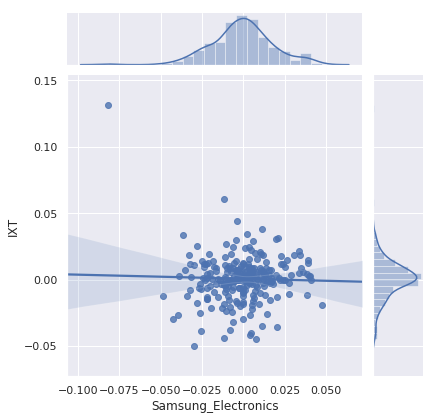

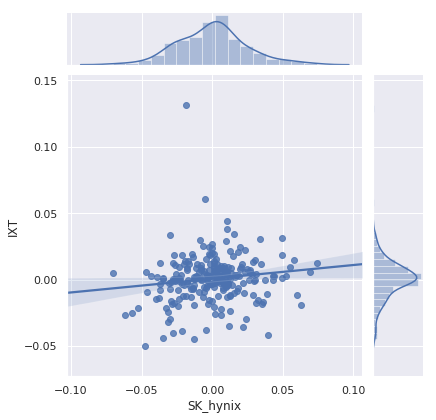

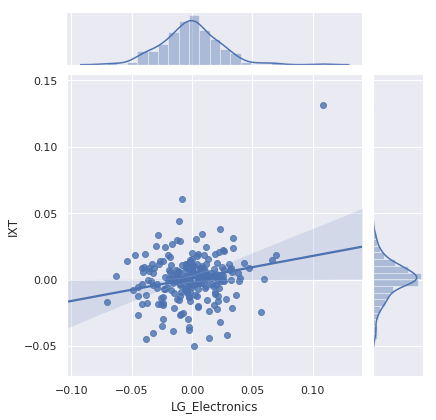

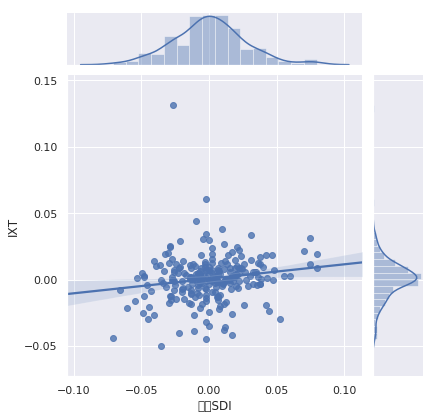

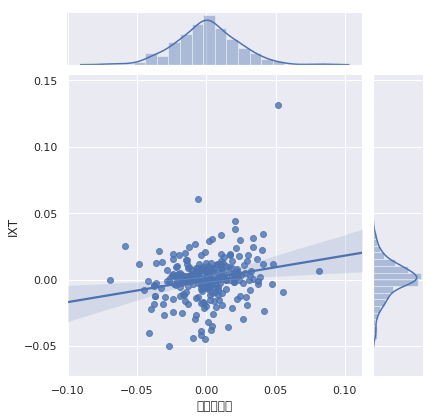

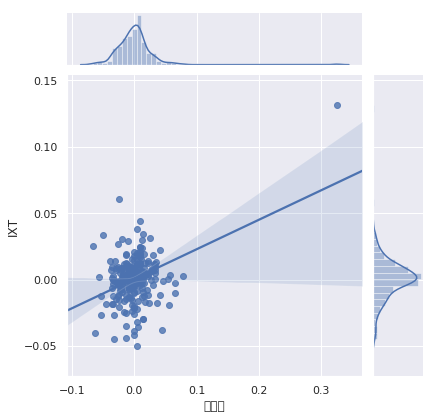

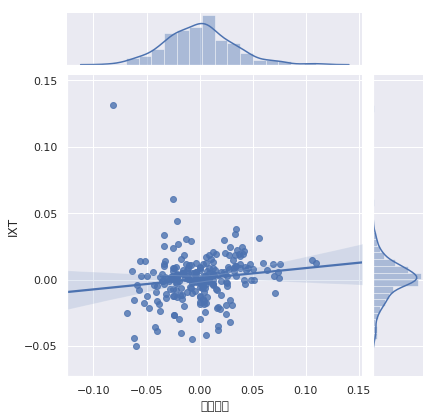

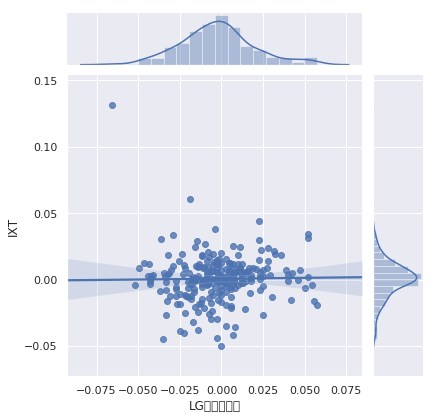

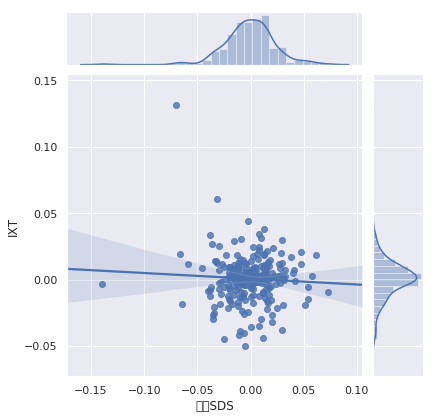

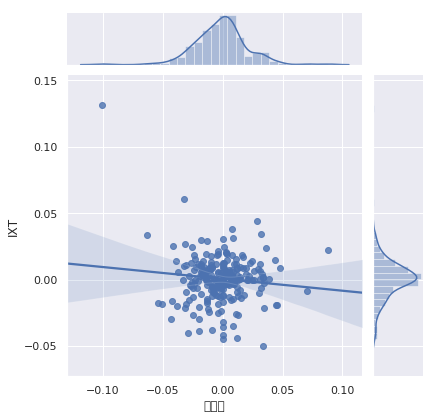

In [13]:
for idx in range(0,len(ten_korean)):
    an.joint(ten_korean[idx],index)

In [45]:
model_fit = ols(target_1+'~1+'+target_2, data=ret_index).fit()
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     Samsung_Electronics   R-squared:                       0.062
Model:                             OLS   Adj. R-squared:                  0.058
Method:                  Least Squares   F-statistic:                     15.78
Date:                 Mon, 20 May 2019   Prob (F-statistic):           9.46e-05
Time:                         20:05:18   Log-Likelihood:                 622.02
No. Observations:                  239   AIC:                            -1240.
Df Residuals:                      237   BIC:                            -1233.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.001     -0.28